In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

#Import standard libraries
import numpy as np
import time
import seaborn as sns
import pandas as pd

from scipy.interpolate import interp1d
from scipy.integrate import simps as simps
from scipy.integrate import cumtrapz as cumtrapz
from scipy.integrate import simps, solve_ivp
from scipy.constants import c as c_light #meters/seconds
c_light_km = c_light/1000 #km/s

import getdist
getdist.chains.print_load_details = False

# import repo functions:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper')
path_figures = os.path.join(path_git, 'notebooks', 'figures')

os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))
from supernovae import aparent_magnitude_th, chi2_supernovae
from constants import OMEGA_R_0, LAMBDA, L, KAPPA

In [2]:
def plot_hubble_parameter(z, Hs, model_name='BETA'):
    """
    Plots the Hubble parameter as a function of Redshift.

    Parameters:
    z (array-like): Array of Redshift values.
    Hs (array-like): Array of Hubble parameter values corresponding to the Redshift values.
    model_name (str): Name of the cosmological model used for the plot title.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(z, Hs, label=f'Hubble Parameter ({model_name} Model)', color='black', linewidth=2)

    # Enhancements
    plt.xlabel('Redshift (z)', fontsize=14)
    plt.ylabel('Hubble Parameter (H(z)) [km/s/Mpc]', fontsize=14)
    plt.title('Hubble Parameter vs Redshift', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.yscale('log')  # Optional: log scale for better visualization
    plt.xscale('log')  # Optional: log scale for better visualization
    plt.minorticks_on()
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.tight_layout()

    # Show plot
    plt.show()


def plot_hubble_parameter_subplots(z, Hs, model_name='BETA'):
    """
    Plots the Hubble parameter and the integrand 1/(H(z)*(1+z)) as subplots.

    Parameters:
    z (array-like): Array of Redshift values.
    Hs (array-like): Array of Hubble parameter values corresponding to the Redshift values.
    model_name (str): Name of the cosmological model used for the plot title.
    """
    # Calculate the integrand
    integrand = 1 / (Hs * (1 + z))

    # Create a DataFrame for Seaborn
    data = pd.DataFrame({'Redshift (z)': z, 'Hubble Parameter (H(z))': Hs, 'Integrand': integrand})

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Hubble parameter
    sns.lineplot(ax=axes[0], data=data, x='Redshift (z)', y='Hubble Parameter (H(z))', label=f'Hubble Parameter ({model_name} Model)', color='black')
    axes[0].set_xlabel('Redshift (z)', fontsize=14)
    axes[0].set_ylabel('Hubble Parameter (H(z)) [km/s/Mpc]', fontsize=14)
    axes[0].set_title('Hubble Parameter vs Redshift', fontsize=16)
    axes[0].legend(fontsize=12)
    axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[0].set_yscale('log')  # Optional: log scale for better visualization
    axes[0].set_xscale('log')  # Optional: log scale for better visualization
    axes[0].minorticks_on()
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].tick_params(axis='both', which='minor', labelsize=10)

    # Plot integrand
    sns.lineplot(ax=axes[1], data=data, x='Redshift (z)', y='Integrand', label='Integrand 1/(H(z)*(1+z))', color='grey')
    axes[1].set_xlabel('Redshift (z)', fontsize=14)
    axes[1].set_ylabel('Integrand 1/(H(z)*(1+z))', fontsize=14)
    axes[1].set_title('Integrand vs Redshift', fontsize=16)
    axes[1].legend(fontsize=12)
    axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[1].set_yscale('log')  # Optional: log scale for better visualization
    axes[1].set_xscale('log')  # Optional: log scale for better visualization
    axes[1].minorticks_on()
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].tick_params(axis='both', which='minor', labelsize=10)

    plt.tight_layout()
    plt.show()


In [3]:

def F_H(H, params, model):     
    lamb, L, beta, L_bar, r, s = params # L and L_bar have to be in units of H0^{-1}
    if model == 'GILA':
        lamb = 0; p = 3; q = 1
        FH = H**2 - beta * H**(2*r) * L_bar**(2*(r-1)) * np.exp(-beta*(L_bar*H)**(2*s)) #\
                  #+ lamb * H**(2*p) * L**(2*(p-1))     * np.exp(lamb*(L*H)**(2*q))

    elif model == 'BETA':
        lamb = 0; p = 1; q = 2; r = 1
        FH = H**2 - beta * H**2                        * np.exp(-beta*(L_bar*H)**(2*s)) #\
                  #+ lamb * H**(2*p) * L**(2*(p-1))     * np.exp(lamb*(L*H)**(2*q))

    return FH


def F_H_prime(H, params, model):
    lamb, L, beta, L_bar, r, s = params # L and L_bar have to be in units of H0^{-1}
   
    if model == 'GILA':
        lamb = 0; p = 3; q = 1
        aux = beta * np.exp(-beta*(L_bar*H)**(2*s)) * (L_bar*H)**(2*(r-1)) * (-r + s * beta * (L_bar*H)**(2*s)) #+\
              #lamb * np.exp(lamb*(L*H)**(2*q))      * (L*H)**(2*(p-1))     * (p  + q * lamb * (L*H)**(2*q))

    elif model == 'BETA':
        lamb = 0; p = 1; q = 2; r = 1
        aux = beta * np.exp(-beta*(L_bar*H)**(2*s))                        * (-1 + s * beta * (L_bar*H)**(2*s)) #+\
              #lamb * np.exp(lamb*(L*H)**(2*q))      * (L*H)**(2*(p-1)) * (p  + q * lamb * (L*H)**(2*q))

    FH_prime = 2 * H * (1 + aux) 
    return FH_prime


def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'LCDM'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    [LAMBDA, L, b, L_bar, H_0, r, s, model] = params_ode #Here L and L_bar are in units of H0^{-1}

    F_H0 = F_H(H_0, [LAMBDA, L, b, L_bar, r, s], model)

    omega_m_0 = F_H0 /(100**2) - OMEGA_R_0

    rho_m_0 = 100**2 * omega_m_0 / KAPPA
    rho_r_0 = 100**2 * OMEGA_R_0 / KAPPA
    
    rho_r = rho_r_0 * (1+z)**4
    rho_m = rho_m_0 * (1+z)**3
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * KAPPA * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [LAMBDA, L, b, L_bar, r, s], model))     
    #print(s)
    return s


def integrator_GILA(physical_params, model, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    #L_bar, b, H0 = physical_params
    L_bar, b, H0, r, s = physical_params
    
    #Cambiar si pasamos de logspace a linspace!
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    
    #ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, model]
    ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, r, s, model]
    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final

In [4]:
def omega_CDM_to_luisa(beta, L_bar, H0, Omega_lcdm, r, s, model):
    factor_inv = H0**2 / F_H(H0, [LAMBDA, L/H0, beta, L_bar/H0, r, s], model) 
    omega_luisa = Omega_lcdm * factor_inv
    return omega_luisa

def params_to_chi2(theta, model, dataset_SN_plus_shoes=None,
                   num_z_points=int(10**5)):

    chi2_SN = 0
    [Mabs, L_bar, b, H_0, r, s] = theta
    physical_params = [L_bar, b, H_0, r, s]
    try:
        zs_model, Hs_model = integrator_GILA(physical_params, model=model, num_z_points=num_z_points,
                                            initial_z=0, final_z=10)
    except Exception as e:
        # If integration fails, reject the step
        return -np.inf

    int_inv_Hs = cumtrapz(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interp = interp1d(zs_model, int_inv_Hs)

    if dataset_SN_plus_shoes != None:
        zhd, zhel, mb, mu_shoes, Cinv, is_cal = dataset_SN_plus_shoes #Import the data
        muobs = mb - Mabs
        muth_num = aparent_magnitude_th(int_inv_Hs_interp, zhd, zhel) #Numeric prediction of mu
        muth = muth_num*(-is_cal + 1) + mu_shoes*(is_cal) #Merge num predicion with mu_shoes
        chi2_SN = chi2_supernovae(muth, muobs, Cinv)


    return chi2_SN

def log_likelihood(*args, **kargs):  
    '''
    Return the log likelihood in terms of the chi square.
    '''
    return -0.5 * params_to_chi2(*args, **kargs)


path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from data import read_data_pantheon_plus_shoes

# Pantheon plus + SH0ES
os.chdir(path_git+'/fr_mcmc/source/Pantheon_plus_shoes')
ds_SN_plus_shoes = read_data_pantheon_plus_shoes('Pantheon+SH0ES.dat',
                                'Pantheon+SH0ES_STAT+SYS.cov')

dof = ds_SN_plus_shoes[2].shape[0]-3


First, let's fix some parameters

In [22]:
#Fix params
omega_r = 2.47e-5 
L_bar = 1.5 #0.90
M_abs = -19.3

Gyr_to_second = int(3.1536e16)
Mpc_to_km = int(3.0857e19)
inv_Hub_to_Gyr = Mpc_to_km/Gyr_to_second

z = np.linspace(0, 1000, int(10e3))
aou_threshold = 12.7


# BETA model analysis

[76.    75.625 75.25  74.875 74.5   74.125 73.75  73.375 73.    72.625
 72.25  71.875 71.5   71.125 70.75  70.375 70.    69.625 69.25  68.875
 68.5   68.125 67.75  67.375 67.   ] [0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.         1.04166667 1.08333333 1.125      1.16666667 1.20833333
 1.25       1.29166667 1.33333333 1.375      1.41666667 1.45833333
 1.5       ]
[<matplotlib.patches.Patch object at 0x7f2d49b68450>, <matplotlib.patches.Patch object at 0x7f2d4967a9d0>, <matplotlib.patches.Patch object at 0x7f2d4d147810>] ['#425041', '#c5debd', '#edebc9'] <matplotlib.colors.ListedColormap object at 0x7f2d49b68a10>


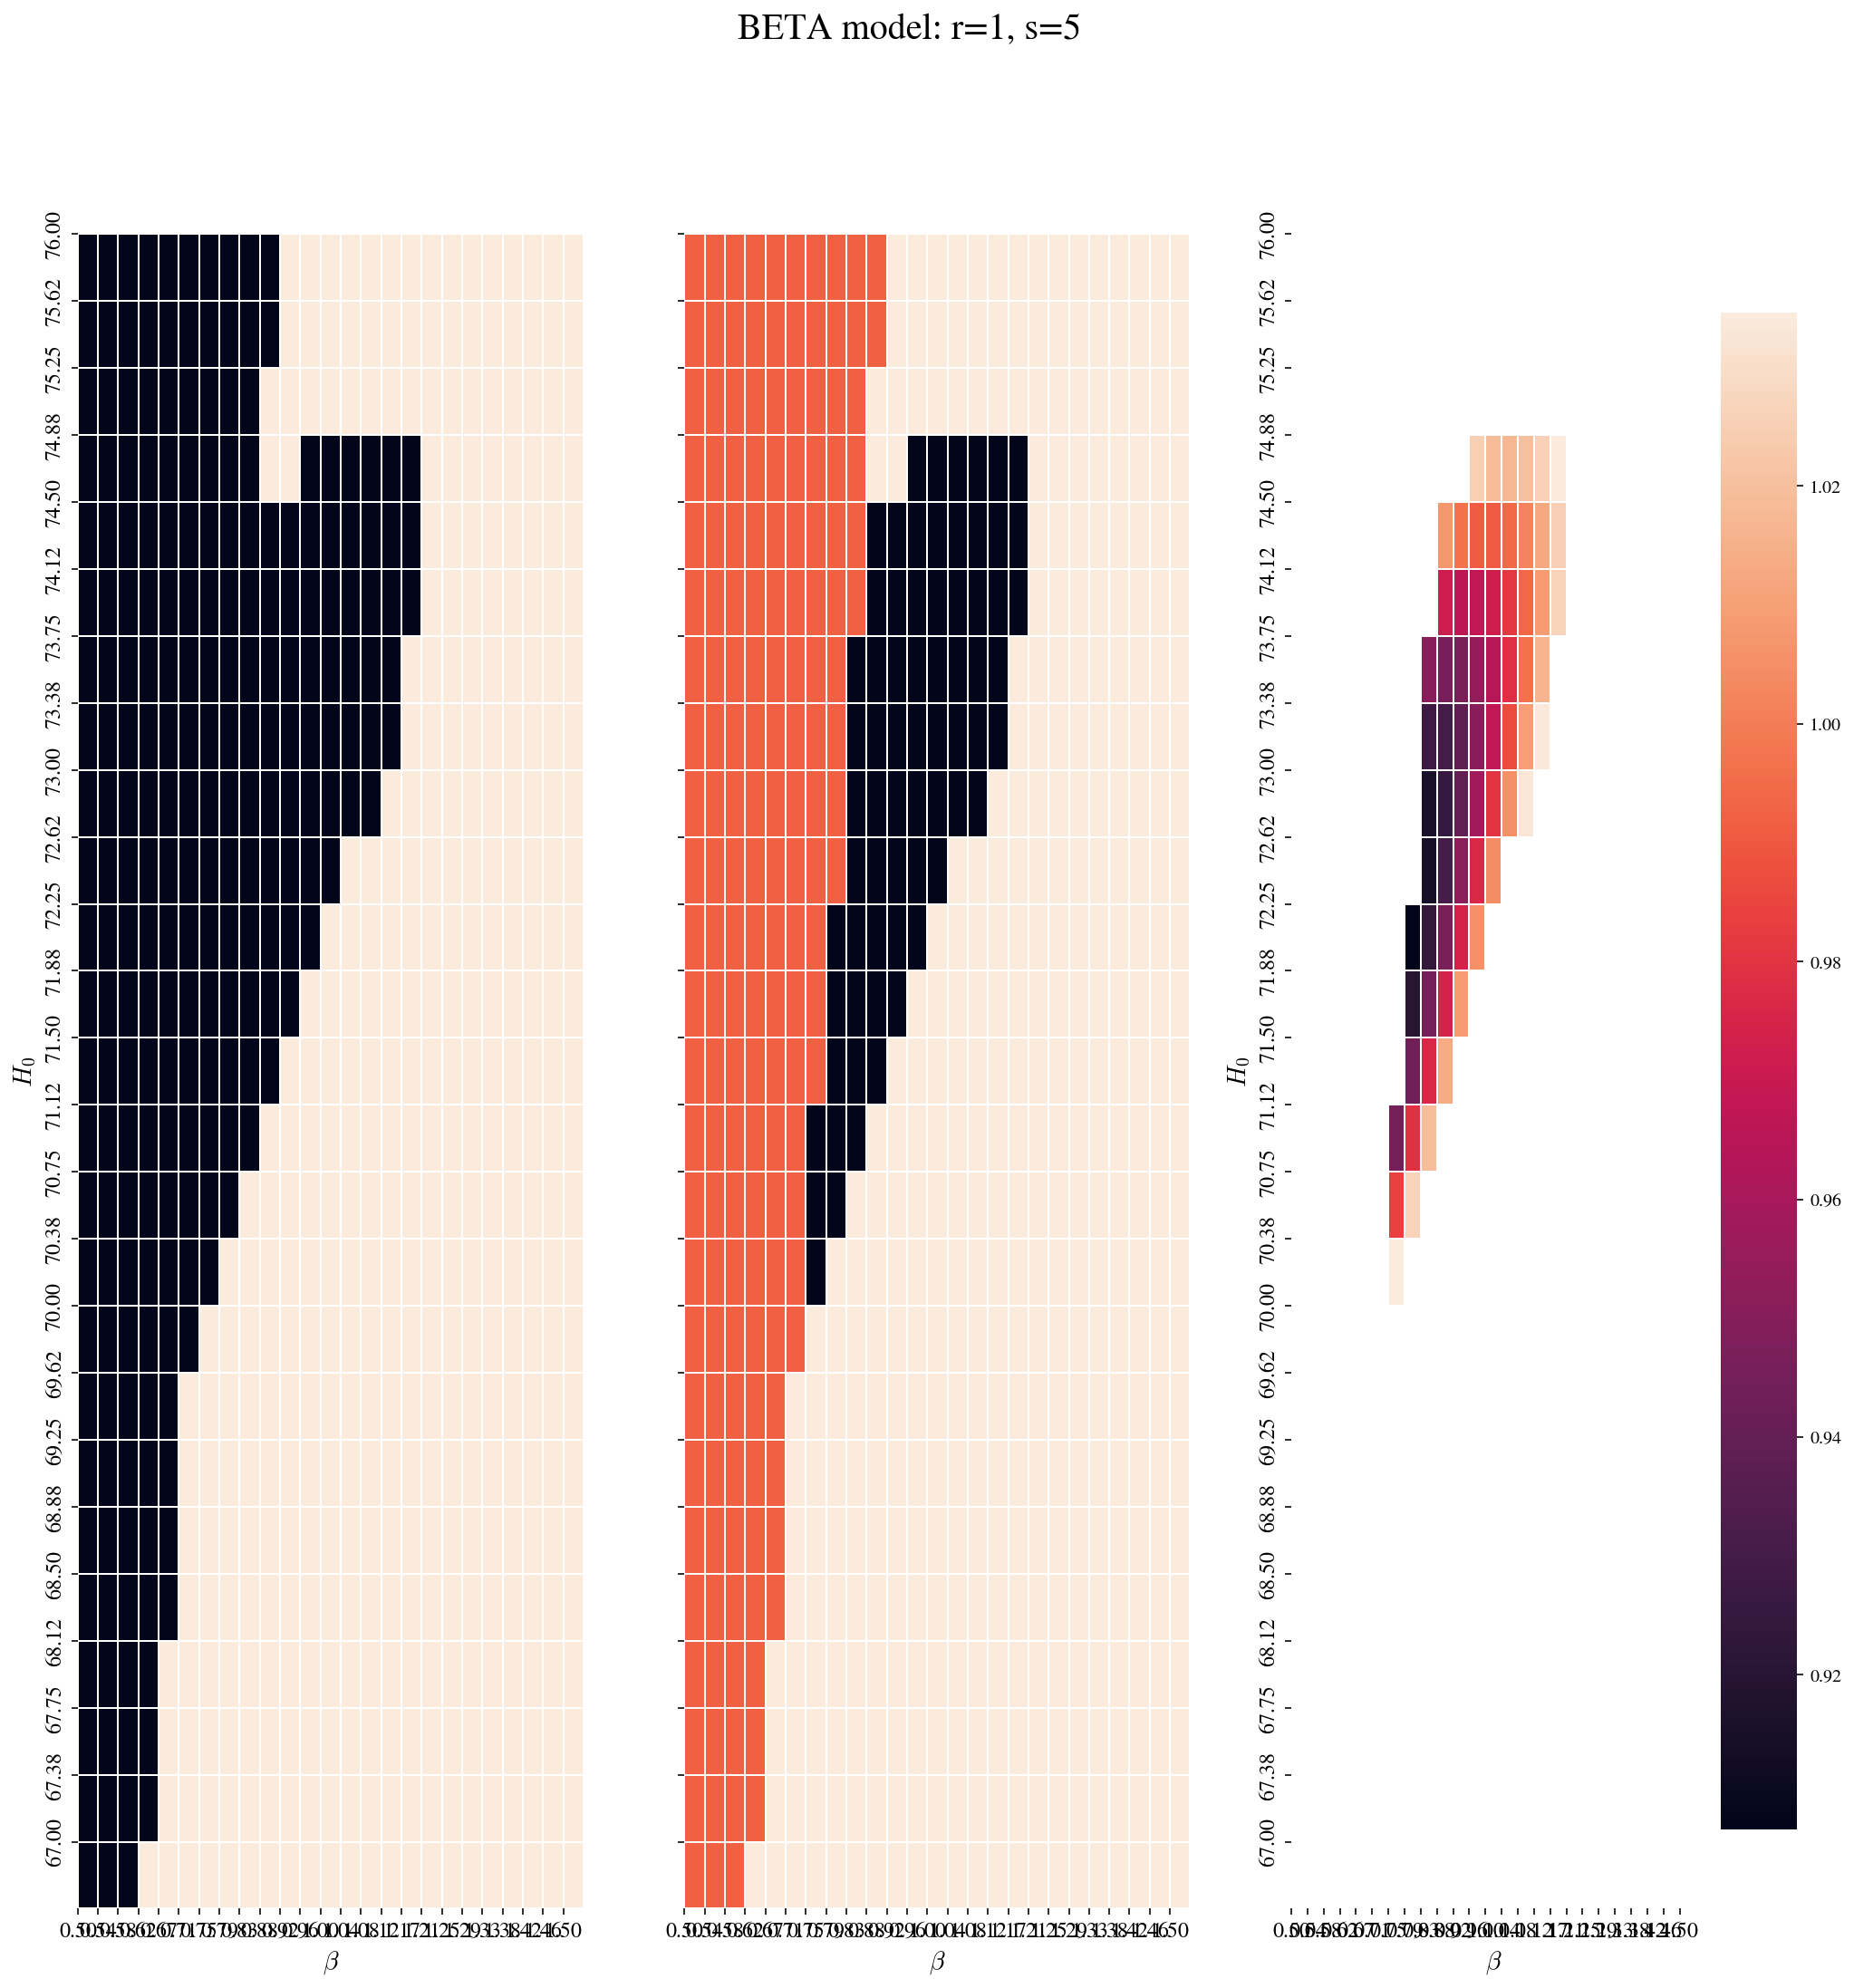

In [17]:
#BETA MODEL
#r_min = 1 (FIX)
#s_min = 2

#s = 2; r = 1 #It worked, not with AoU
#H0_values = np.linspace(67,74.5,25)[::-1] 
#beta_values = np.linspace(0.01,5,25)

#s = 3; r = 1 #It worked, not with AoU
#H0_values = np.linspace(67,76,25)[::-1] 
#beta_values = np.linspace(0.01,8,25)

#s = 4; r = 1  #It worked, even with AoU!
#H0_values = np.linspace(67,76,25)[::-1] 
#beta_values = np.linspace(0.01,10,25)

s = 5; r = 1  #It worked, even with AoU!
H0_values = np.linspace(67,76,25)[::-1] 
beta_values = np.linspace(0.5,1.5,25)

#s = 6; r = 1  #It worked, even with AoU!
#H0_values = np.linspace(67,76,25)[::-1] 
#beta_values = np.linspace(0.5,1.5,25)


print(H0_values, beta_values)

matrix_beta = np.zeros((len(H0_values), len(beta_values)))
matrix_beta_aou = np.zeros((len(H0_values), len(beta_values)))
matrix_beta_chi2 = np.zeros((len(H0_values), len(beta_values)))

for i, H0_val in enumerate(H0_values):
    for j, beta_val in enumerate(beta_values):
        physical_params = [L_bar, beta_val, H0_val, r, s]
        try :        
            z_final, Hs_final = integrator_GILA(physical_params, model='BETA', num_z_points=int(len(z)),
                                            initial_z=z[0], final_z=z[-1])
        except Exception as e:
            # If integration fails
            matrix_beta[i, j] = 1
            matrix_beta_aou[i, j] = 1
            matrix_beta_chi2[i, j] = np.nan
            continue
        aou_beta = inv_Hub_to_Gyr * simps(((1+z_final) * Hs_final)**(-1), z_final)
        if aou_beta < aou_threshold:
            matrix_beta_aou[i, j] = 2
            matrix_beta_chi2[i, j] = np.nan
        else:
            theta = [M_abs, L_bar, beta_val, H0_val, r, s]
            chi2 = params_to_chi2(theta, dataset_SN_plus_shoes=ds_SN_plus_shoes, model='BETA')#/dof
            if chi2 > dof +np.sqrt(2*dof):
                matrix_beta[i, j] = 3
                matrix_beta_aou[i, j] = 3
                matrix_beta_chi2[i, j] = np.nan
            else:
                matrix_beta[i, j] = 0
                matrix_beta_aou[i, j] = 0
                matrix_beta_chi2[i, j] = chi2 / dof

'''
3: chi2 > dof + sqrt(2*dof)
2: AOU < 12.7 Gyr
1: bad integration
'''

# Create a dictionary mapping values to labels
value_to_label = {
    2: 'AOU < 12.7 Gyr',
    3: r'$\chi^2 > \chi^2_{\rm dof} + \sqrt{2 \chi^2_{\rm dof}}$',
    1: 'Integration Error'
}

# Create a dictionary mapping values to colors
value_to_color = {
    2: '#425041',
    3: '#c5debd',
    1: '#edebc9'
}

# Create the colormap using the colors from the dictionary
colors = [value_to_color[key] for key in value_to_color.keys()]
cmap = ListedColormap(colors)

# Create custom legend handles using the dictionary
legend_handles = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(value_to_label.values())]

print(legend_handles,colors,cmap)

# Plot BETA model
fig, axes = plt.subplots(1,3,figsize=(17, 17))
fig.suptitle(r'BETA model: r={0}, s={1}'.format(r,s), fontsize=20) 

#sns.heatmap(matrix_beta / dof, ax=axes[0], linewidth=0.5)
#sns.heatmap(matrix_beta, cmap=cmap, cbar=False, ax=axes[0], linewidth=0.5)
sns.heatmap(matrix_beta, cbar=False, ax=axes[0], linewidth=0.5)

#sns.heatmap(matrix_beta_aou / dof, ax=axes[1], linewidth=0.5)
#sns.heatmap(matrix_beta_aou, cmap=cmap, cbar=False, ax=axes[1], linewidth=0.5)
sns.heatmap(matrix_beta_aou, cbar=False, ax=axes[1], linewidth=0.5)

sns.heatmap(matrix_beta_chi2, cbar=True, ax=axes[2], linewidth=0.5)

# General configurations for all axes
for ax in axes.flat:
    ax.legend(handles=legend_handles, loc='upper right', fontsize=12) # Add legend to ax
    ax.set_xlabel(r'$\beta$', fontsize=14)
    ax.set_ylabel(r'$H_0$', fontsize=14)
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_xticks(np.arange(len(beta_values)))
    ax.set_yticks(np.arange(len(H0_values)))
    ax.set_xticklabels([f'{tick:.2f}' for tick in beta_values])
    ax.set_yticklabels([f'{tick:.2f}' for tick in H0_values])
    ax.label_outer()
fig.savefig(os.path.join(path_figures, 'heat_map_aou_BETA_r={0}_s={1}_Lbar={2}.png'.format(r,s,L_bar)))
plt.show()

# GILA model analysis

[80.         79.16666667 78.33333333 77.5        76.66666667 75.83333333
 75.         74.16666667 73.33333333 72.5        71.66666667 70.83333333
 70.         69.16666667 68.33333333 67.5        66.66666667 65.83333333
 65.         64.16666667 63.33333333 62.5        61.66666667 60.83333333
 60.        ] [0.2   0.525 0.85  1.175 1.5   1.825 2.15  2.475 2.8   3.125 3.45  3.775
 4.1   4.425 4.75  5.075 5.4   5.725 6.05  6.375 6.7   7.025 7.35  7.675
 8.   ]
[<matplotlib.patches.Patch object at 0x7f2d4d137150>, <matplotlib.patches.Patch object at 0x7f2d4d470ed0>, <matplotlib.patches.Patch object at 0x7f2d499c3cd0>] ['#425041', '#c5debd', '#edebc9'] <matplotlib.colors.ListedColormap object at 0x7f2d4d137c90>


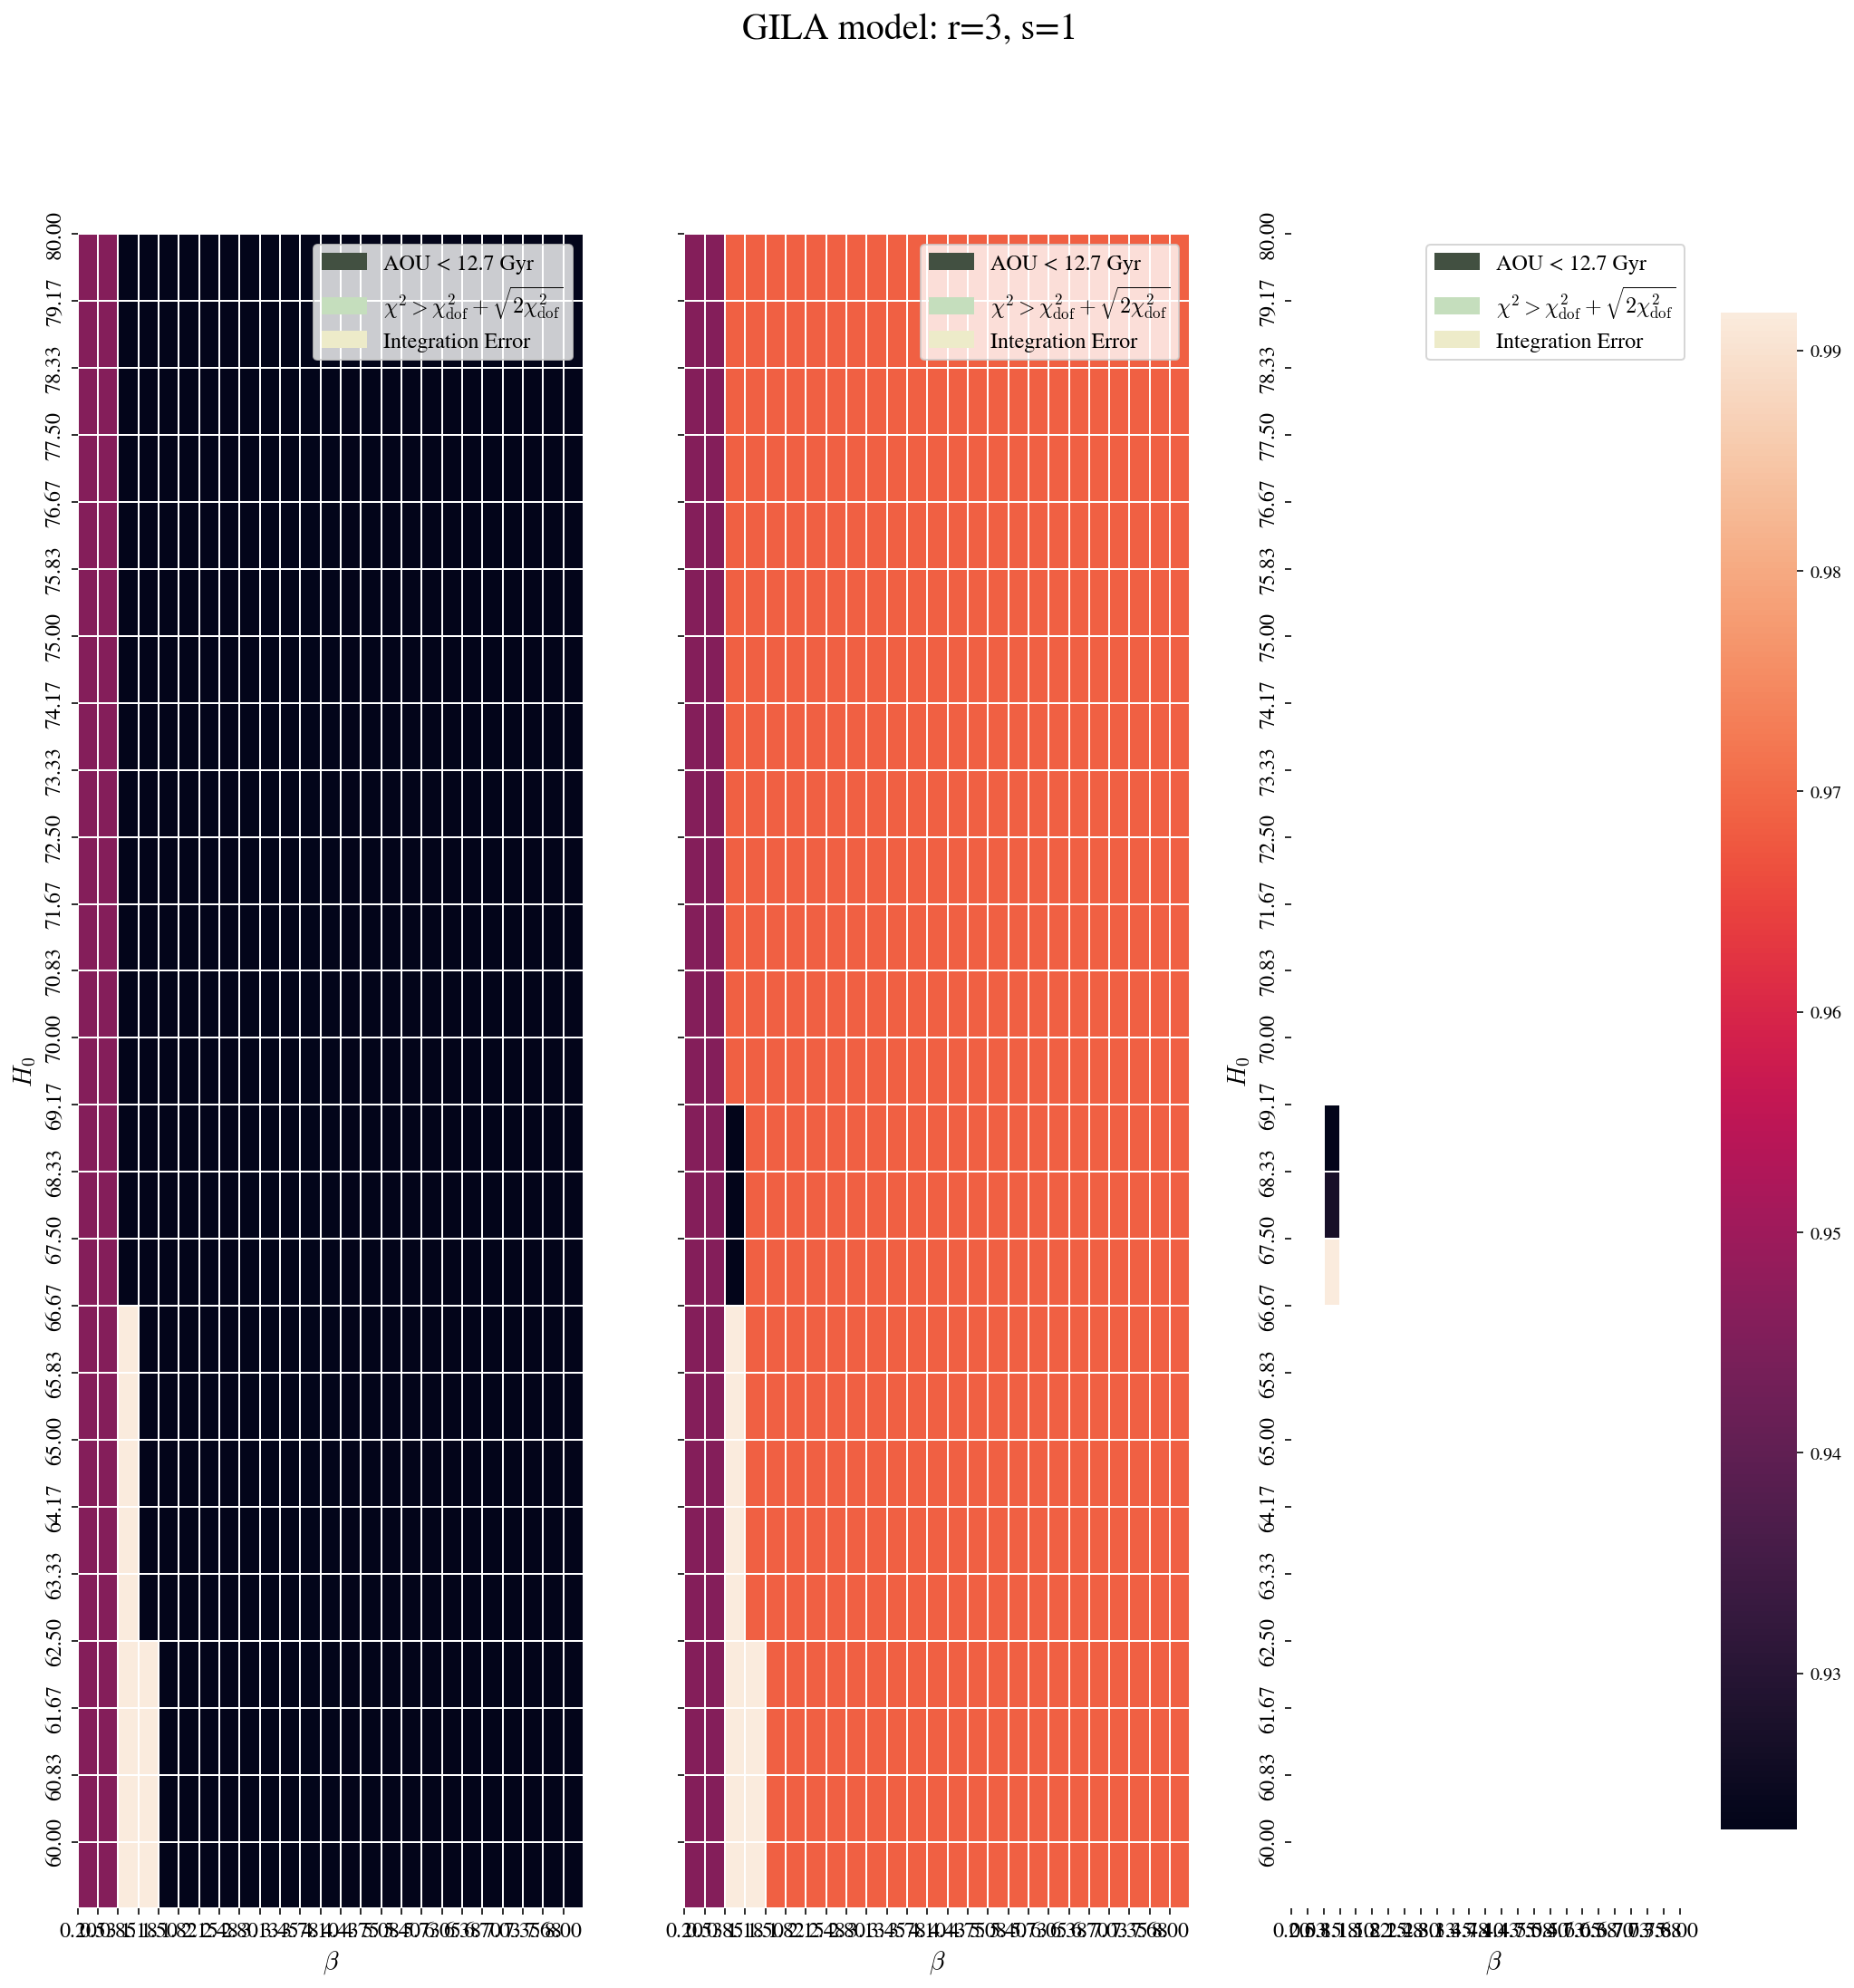

In [23]:
#GILA MODEL
#r_min = 3
#s_min = 1

#r = 3; s = 1 #Does not work :(
#H0_values = np.linspace(60,80,25)[::-1] 
#beta_values = np.linspace(0.2,8,25)

#r = 8; s = 1 #Does not work :(
#H0_values = np.linspace(60,80,25)[::-1] 
#beta_values = np.linspace(1,80,25)

#r = 3; s = 2 #It works, not with AoU
#H0_values = np.linspace(64,74,25)[::-1] 
#beta_values = np.linspace(0.8,4,25)

#r = 3; s = 4 #It works, not with AoU
#H0_values = np.linspace(64,78,25)[::-1] 
#beta_values = np.linspace(0.3,8,25)

r = 3; s = 5 #It worked, even with AoU!
H0_values = np.linspace(64,78,25)[::-1] 
beta_values = np.linspace(0.3,8,25)

#r = 3; s = 6 #It worked, even with AoU!
#H0_values = np.linspace(64,78,25)[::-1] 
#beta_values = np.linspace(0.3,4,25)


print(H0_values, beta_values)


matrix_gila = np.zeros((len(H0_values), len(beta_values)))
matrix_gila_aou = np.zeros((len(H0_values), len(beta_values)))
matrix_gila_chi2 = np.zeros((len(H0_values), len(beta_values)))

for i, H0_val in enumerate(H0_values):
    for j, beta_val in enumerate(beta_values):
        physical_params = [L_bar, beta_val, H0_val, r, s]
        try :        
            z_final, Hs_final = integrator_GILA(physical_params, model='GILA', num_z_points=int(len(z)),
                                            initial_z=z[0], final_z=z[-1])
        except Exception as e:
            # If integration fails
            matrix_gila[i, j] = 1
            matrix_gila_aou[i, j] = 1
            matrix_gila_chi2[i, j] = np.nan
            continue
        aou_gila = inv_Hub_to_Gyr * simps(((1+z_final) * Hs_final)**(-1), z_final)
        if aou_gila < aou_threshold:
            matrix_gila_aou[i, j] = 2
            matrix_gila_chi2[i, j] = np.nan
        else:
            theta = [M_abs, L_bar, beta_val, H0_val, r, s]
            chi2 = params_to_chi2(theta, dataset_SN_plus_shoes=ds_SN_plus_shoes, model='GILA')#/dof
            if chi2 > dof +np.sqrt(2*dof):
                matrix_gila[i, j] = 3
                matrix_gila_aou[i, j] = 3
                matrix_gila_chi2[i, j] = np.nan
            else:
                matrix_gila[i, j] = 0
                matrix_gila_aou[i, j] = 0
                matrix_gila_chi2[i, j] = chi2 / dof

'''
3: chi2 > dof + sqrt(2*dof)
2: AOU < 12.7 Gyr
1: bad integration
'''

# Create a dictionary mapping values to labels
value_to_label = {
    2: 'AOU < 12.7 Gyr',
    3: r'$\chi^2 > \chi^2_{\rm dof} + \sqrt{2 \chi^2_{\rm dof}}$',
    1: 'Integration Error'
}

# Create a dictionary mapping values to colors
value_to_color = {
    2: '#425041',
    3: '#c5debd',
    1: '#edebc9'
}

# Create the colormap using the colors from the dictionary
colors = [value_to_color[key] for key in value_to_color.keys()]
cmap = ListedColormap(colors)

# Create custom legend handles using the dictionary
legend_handles = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(value_to_label.values())]

print(legend_handles,colors,cmap)

# Plot BETA model
fig, axes = plt.subplots(1,3,figsize=(17, 17))
fig.suptitle(r'GILA model: r={0}, s={1}'.format(r,s), fontsize=20) 

#sns.heatmap(matrix_gila / dof, ax=axes[0], linewidth=0.5)
#sns.heatmap(matrix_gila, cmap=cmap, cbar=False, ax=axes[0], linewidth=0.5)
sns.heatmap(matrix_gila, cbar=False, ax=axes[0], linewidth=0.5)

#sns.heatmap(matrix_gila_aou / dof, ax=axes[1], linewidth=0.5)
#sns.heatmap(matrix_gila_aou, cmap=cmap, cbar=False, ax=axes[1], linewidth=0.5)
sns.heatmap(matrix_gila_aou, cbar=False, ax=axes[1], linewidth=0.5)

sns.heatmap(matrix_gila_chi2, cbar=True, ax=axes[2], linewidth=0.5)

# General configurations for all axes
for ax in axes.flat:
    ax.legend(handles=legend_handles, loc='upper right', fontsize=12) # Add legend to ax
    ax.set_xlabel(r'$\beta$', fontsize=14)
    ax.set_ylabel(r'$H_0$', fontsize=14)
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_xticks(np.arange(len(beta_values)))
    ax.set_yticks(np.arange(len(H0_values)))
    ax.set_xticklabels([f'{tick:.2f}' for tick in beta_values])
    ax.set_yticklabels([f'{tick:.2f}' for tick in H0_values])
    ax.label_outer()
fig.savefig(os.path.join(path_figures, 'heat_map_aou_GILA_r={0}_s={1}_Lbar={2}.png'.format(r,s,L_bar)))
plt.show()